In [1]:
from utils import (
    sig,
    sigfit,
    TwoFlashesProcessingStrategy,
    TwoFlashesProcessingStrategy_Explore,
)

## Experimental Data

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

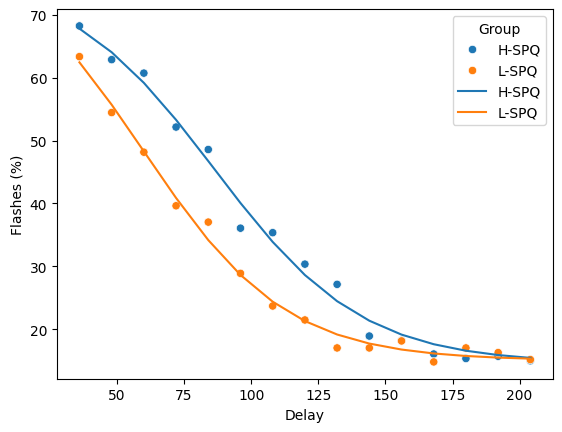

In [3]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

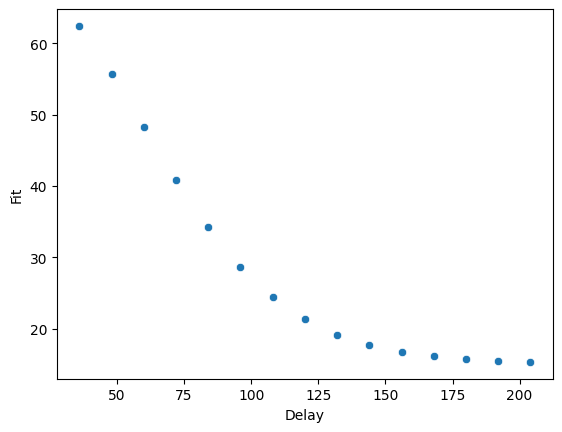

In [4]:
# Data to fit
lspq_data = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'L-SPQ'"), y="Fit", x="Delay")

## Fitting model

In [ ]:
from skneuromsi.neural import Paredes2025
from skneuromsi.sweep import ParameterSweep
from scipy.optimize import differential_evolution
import numpy as np


def two_flashes_job(a_tau, v_tau, m_tau, cm_weight, fb_weight, ff_weight):

    model = Paredes2025(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=1,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
    )

    return res


def baseline_cost(theta):

    exp_data = lspq_data
    model_data = two_flashes_job(
        a_tau=theta[0],
        v_tau=theta[1],
        m_tau=theta[2],
        cm_weight=theta[3],
        fb_weight=theta[4],
        ff_weight=theta[5],
    )

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(6, 20), (6.25, 60), (6, 120), (0.001, 0.05), (0.001, 1), (0.001, 15)]

baseline_fit_res = differential_evolution(
    baseline_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=30,
    polish=False,
)

In [ ]:
print(baseline_fit_res)

   
            message: Optimization terminated successfully.
            success: True
                fun: 0.00475311279296875
                  x: [ 6.560e+00  9.191e+00  1.200e+02  1.036e-03
                       6.231e-01  3.892e+00]
                nit: 262
               nfev: 23670
         population: [[ 6.560e+00  9.191e+00 ...  6.231e-01  3.892e+00]
                      [ 6.556e+00  9.192e+00 ...  6.230e-01  3.893e+00]
                       ...
                      [ 6.571e+00  9.187e+00 ...  6.235e-01  3.890e+00]
                      [ 6.555e+00  9.172e+00 ...  6.245e-01  3.916e+00]]
population_energies: [ 4.753e-03  4.780e-03 ...  4.879e-03  4.799e-03]
      


## Fitting model without Causal Inference area

In [ ]:
from skneuromsi.neural import Paredes2025
from skneuromsi.sweep import ParameterSweep
from scipy.optimize import differential_evolution
import numpy as np


def two_flashes_job(a_tau, v_tau, cm_weight):

    model = Paredes2025(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, 6),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=1,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=0,
        feedforward_weight=0,
    )

    return res


def baseline_cost(theta):

    exp_data = lspq_data
    model_data = two_flashes_job(a_tau=theta[0], v_tau=theta[1], cm_weight=theta[2])
    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(6, 20), (6.25, 60), (0.001, 0.05)]

baseline_fit_res = differential_evolution(
    baseline_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=30,
    polish=False,
)

differential_evolution step 1: f(x)= 13.199831883115923
differential_evolution step 2: f(x)= 13.075242217209212
differential_evolution step 3: f(x)= 13.07037960907006
differential_evolution step 4: f(x)= 12.823535456464693
differential_evolution step 5: f(x)= 12.823535456464693
differential_evolution step 6: f(x)= 12.791040430751027
differential_evolution step 7: f(x)= 12.775963893942228
differential_evolution step 8: f(x)= 12.766216130470408
differential_evolution step 9: f(x)= 12.740431753018722
differential_evolution step 10: f(x)= 12.740431753018722
differential_evolution step 11: f(x)= 12.721479562518097
differential_evolution step 12: f(x)= 12.721479562518097
differential_evolution step 13: f(x)= 12.721479562518097
differential_evolution step 14: f(x)= 12.721479562518097
differential_evolution step 15: f(x)= 12.721479562518097
differential_evolution step 16: f(x)= 12.721479562518097
differential_evolution step 17: f(x)= 12.720672853411068
differential_evolution step 18: f(x)= 12.

In [ ]:
print(baseline_fit_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 12.71639842872268
                   x: [ 1.981e+01  2.559e+01  4.928e-02]
                 nit: 23
                nfev: 1080
          population: [[ 1.981e+01  2.559e+01  4.928e-02]
                       [ 1.983e+01  2.663e+01  4.772e-02]
                       ...
                       [ 1.958e+01  2.664e+01  4.781e-02]
                       [ 1.953e+01  2.602e+01  4.950e-02]]
 population_energies: [ 1.272e+01  1.274e+01 ...  1.275e+01  1.272e+01]

## Exploration

In [5]:
from skneuromsi.neural import Paredes2025
from skneuromsi.sweep import ParameterSweep


def two_flashes_job(a_tau, v_tau, m_tau, cm_weight, fb_weight, ff_weight):

    model = Paredes2025(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy_Explore(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
    )

    return res


results_list, two_flashes_res, _ = two_flashes_job(
    a_tau=6.560e00,
    v_tau=9.191e00,
    m_tau=1.200e02,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
import numpy as np

sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, two_flashes_res)
print(a, b, c, d)
two_flashes_model_data = sig(sig_soas, a, b, c, d)

15.52264730654774 57.97741783929789 67.00918625411056 -23.102923640139778


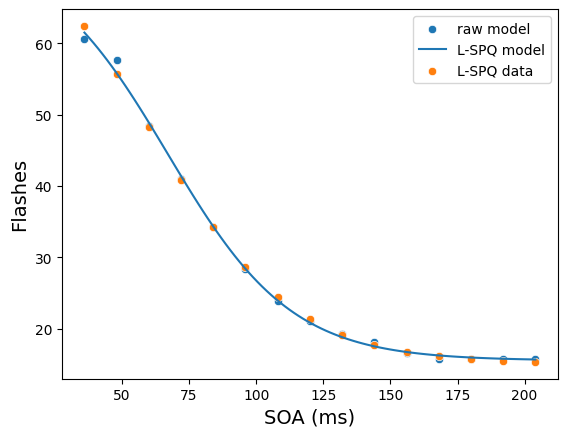

In [7]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=two_flashes_res, label="raw model")
sns.lineplot(x=sig_soas, y=two_flashes_model_data, label="L-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'L-SPQ'"), y="Fit", x="Delay", label="L-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

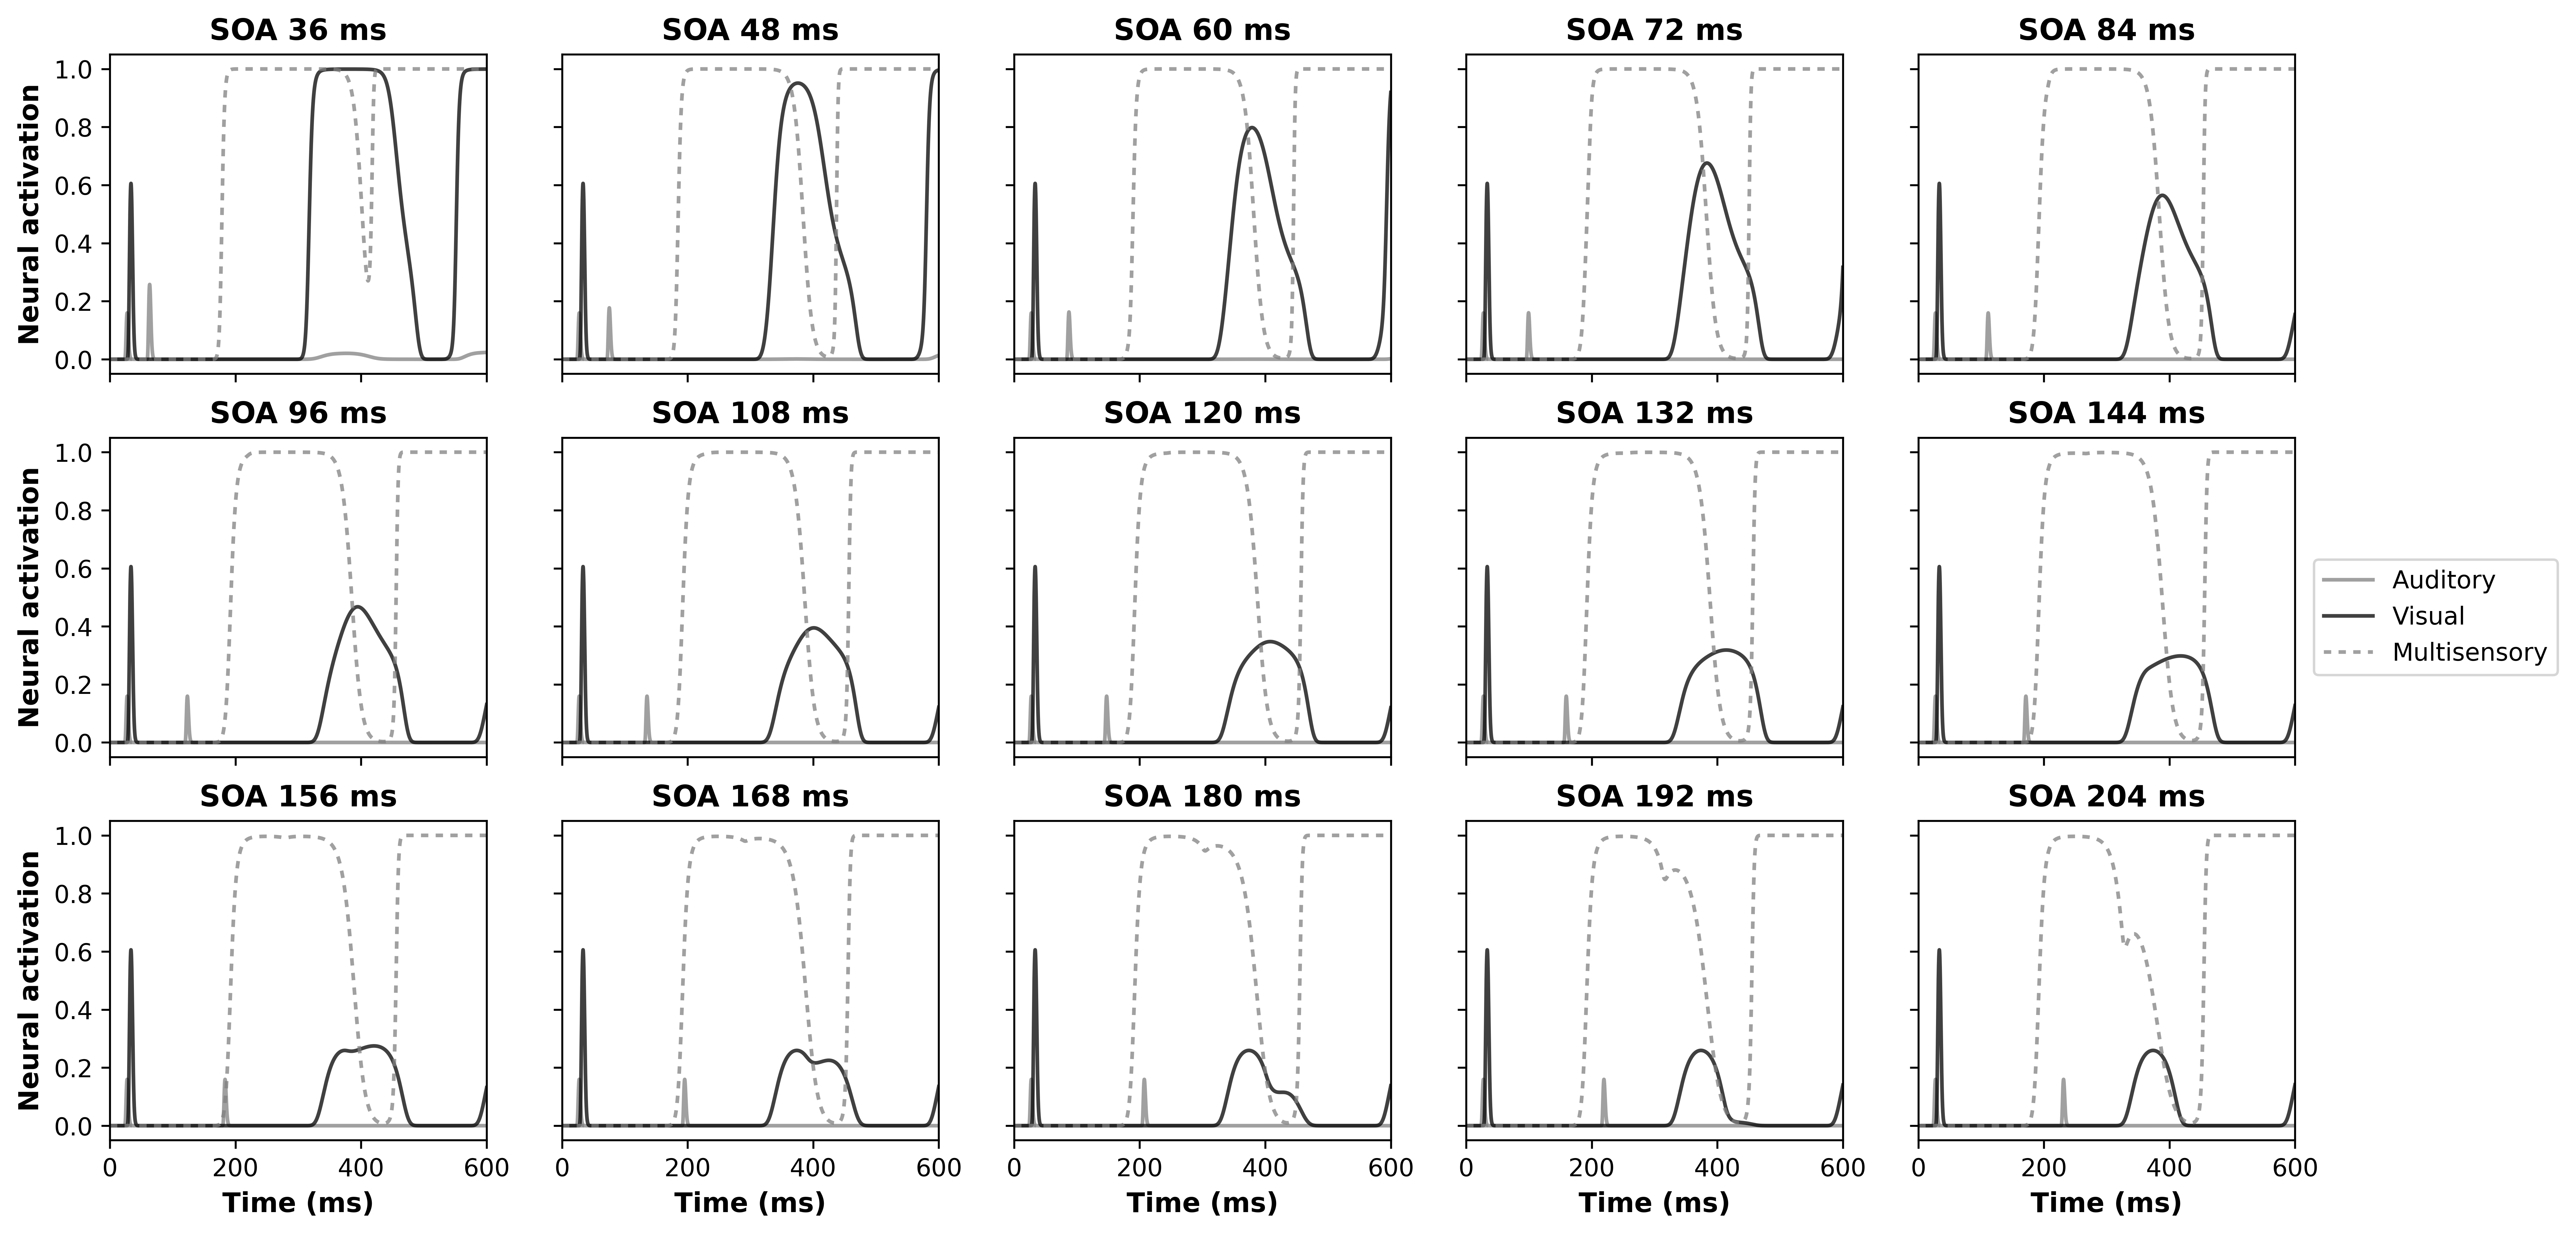

In [ ]:
from utils import plot_res_per_soa

plot_res_per_soa(results_list)